# ARIMA forecasting 📈

Objectives:
* Walk-through the steps involved in time series forecasting
* Introduce ARIMA models
* Use an arima model to make a forecast
* Excercise: forecasting animal skins (time to practice!)
# 🐱

In [1]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns
import matplotlib.style as style
# style.use('ggplot')

#!pip install pmdarima==1.5.2
import pmdarima as pmd
pmd.__version__  #should be version 1.5.2


'1.8.2'

# Example 1 - airline passenger forecasts ✈️ 💺

Our goal here is to forecast the number of air-travel passengers (per month) over the next 12 months using historical data.

Get the airline passenger data




In [6]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

In [7]:
airline

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Length: 144, dtype: float64

Rather than a random train test split, when analysing time series data we must use the most recent data as the **testing set**.

TODO: Write a function which splits a dataset (a dataframe with time as index) and returns a train and test datasets, this function will have the split date as an argument.


In [8]:
airline[:'1950-01-01']

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
1950-01-01    115.0
Freq: MS, dtype: float64

In [9]:
airline.loc['1950-01-01':]

1950-01-01    115.0
1950-02-01    126.0
1950-03-01    141.0
1950-04-01    135.0
1950-05-01    125.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Length: 132, dtype: float64

In [10]:
test, train= airline.loc[:'1950-01-01'].iloc[:-1], airline.loc['1950-01-01':]

In [11]:
test

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
Freq: MS, dtype: float64

In [12]:
train

1950-01-01    115.0
1950-02-01    126.0
1950-03-01    141.0
1950-04-01    135.0
1950-05-01    125.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Length: 132, dtype: float64

In [13]:
## Write your code here
def ts_train_test_split(df,split_date):
    """Splits a dataset (a dataframe with time as index) and returns a train and test datasets.
    This function will have the split date as an argument"""
    train = df.loc[:str(split_date)].iloc[:-1]
    test = df.loc[str(split_date):]
    return train, test

In [14]:
# hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline, '1960-01-01')

In [15]:
len(airline)

144

In [16]:
#### check trian and test sizes are what we expect
len(train)

132

In [17]:
train

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
Freq: MS, Length: 132, dtype: float64

In [18]:
len(test)

12

## Explore TRAIN data

Like any prediction process we explore the data set to gain insights. But (as always) we only plot the TRAIN data! 

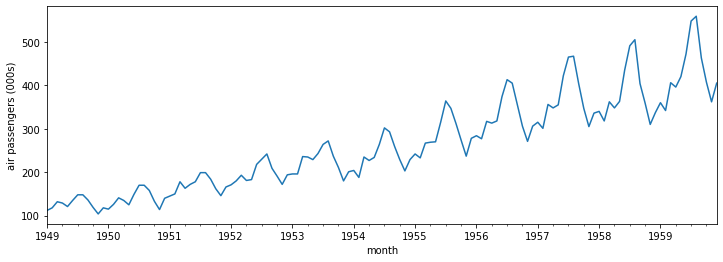

In [19]:
ax = train.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='air passengers (000s)');

Different months have different numbers of days. Soetimes we need to do what we can to make things easier for our model. Calcuating number of passengers per day might help remove some variation from the series...

In [20]:
train

1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
Freq: MS, Length: 132, dtype: float64

In [21]:
train.index.days_in_month

Int64Index([31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
            ...
            31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           dtype='int64', length=132)

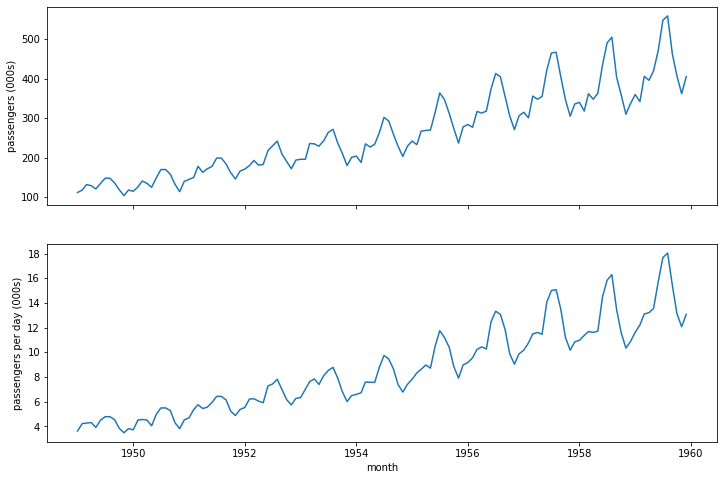

In [22]:
train_adj = train / train.index.days_in_month
test_adj = train / train.index.days_in_month

#plot the adjusted and unadjusted series
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].figsize = (12, 10)

axes[0].plot(train)
axes[0].set(ylabel='passengers (000s)');

axes[1].plot(train_adj)
axes[1].set(xlabel='month', ylabel='passengers per day (000s)');

#### Explore subcomponents in series.

Before performing a forecast it is worth decomposing the time series into its components of trend, seasonality and noise.

* statsmodels has function called `seasonal_decompose()` for this task

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
sd_result = seasonal_decompose(train_adj, model='multiplicative')

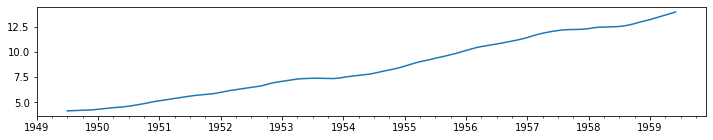

In [25]:
ax = sd_result.trend.plot(figsize=(12,2))

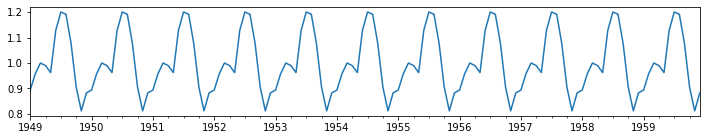

In [26]:
ax = sd_result.seasonal.plot(figsize=(12,2))

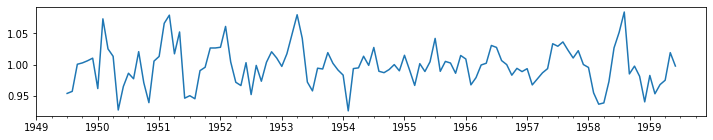

In [27]:
ax = sd_result.resid.plot(figsize=(12,2))

## Naive forecasting

We need a baseline (as always!) to know if our more complex models are any use! We explore two here:
* seasonal naive - a model which just takes the same period from the previous season. ( in this case the same month last year)
* naive - just carry forward the last value in the series

Given the strong seasonal component that was confirmed by the seasonal decomposition it may be a good idea to use a **seasonal naive** forecasting method.  This is part of the 'carry forward previous values' family of *naive* forecasting methods.  In general, if we have data with period $k$ are at time $t$ and we are predicting time $Y_{t+1}$ then we simply carry forward the value from $Y_{t+1-k}$. In other words we have yearly data so we just take the value from the same month last year.

In [28]:
!pip install forecast

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from forecast.baseline import Naive1, SNaive #mettre le module à importer dans le même dossier que le notebook

HORIZON = 12 # we plan to make forecasts for the following 12 months
PERIOD = 12 # period is the period of seasonality we expect

In [30]:
# using seasonal naive
snf = SNaive(period=PERIOD)
snf.fit(train_adj)
insample_predictions = snf.fittedvalues

To see what this is doing lets plot its predictions for the whole TRAIN data set to which it has been fitted.

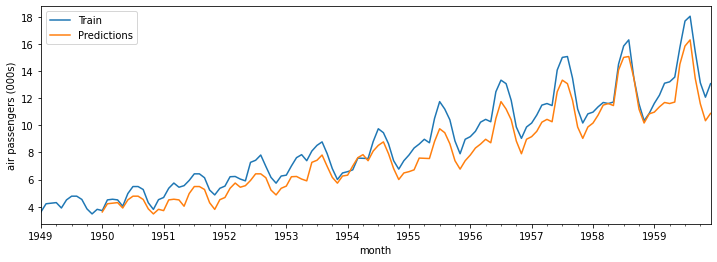

In [31]:
ax = train_adj.plot(figsize=(12,4))
insample_predictions.plot(ax=ax)
ax.set(xlabel='month', ylabel='air passengers (000s)');
ax.legend(['Train', 'Predictions'])

Plotting the **residuals** can give us information about how the model is performing and the errors it is making.  Sometimes there are reffered to as **in sample** diagnostics. This just means we are looking at diagnostics of data which has been used to fit the model. 

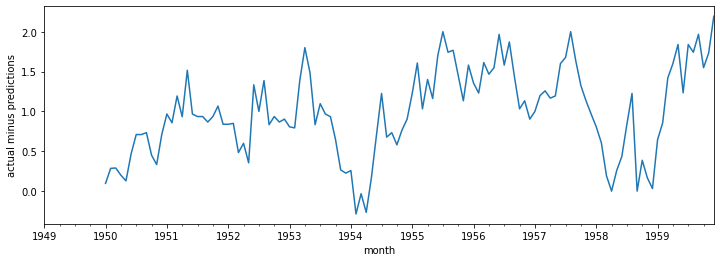

In [32]:
ax = snf.resid.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='actual minus predictions');

/home/d5learner-15/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resid', ylabel='Density'>

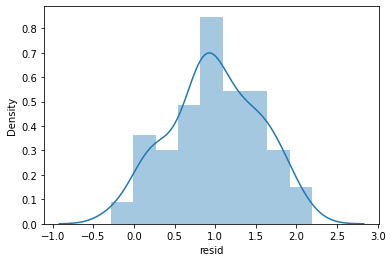

In [33]:
sns.distplot(snf.resid.dropna())

#### evaluating error

In the past we have done this. 

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
np.sqrt(mean_squared_error(train_adj[PERIOD:], insample_predictions[PERIOD:])) # we do not have predictions for the first period

1.1317282236397845

For timeseries there are other approaches...

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = 100e_t/y_t$ where $e_t$ is the error in predicting $y_t$.  Therefore, MAPE = $mean(|p_t|)$. A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It is also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
mean_absolute_percentage_error(train_adj[PERIOD:], insample_predictions[PERIOD:])

11.377828929635351

## Task: Perform the same analysis for the naive prediction

* Have a go at using the `Naive1()` class.  It follows the same pattern as SNaive interface.  Instantiate a class.  call the `.fit(y_train)` method and then use the `.fittedvalues` and `.resid` properties for diagnostics.  
* Calculate the in-sample RMSE and MAPE
* What happens to the insample residuals if you fit the raw training data to the model?

In [38]:
##### answer here

naive1 = Naive1()
naive1.fit(train_adj)
insample_predictions1 = naive1.fittedvalues

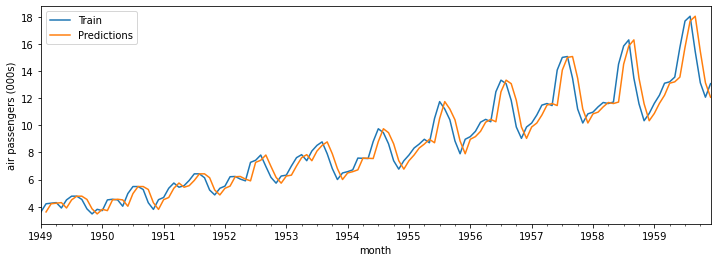

In [39]:
ax = train_adj.plot(figsize=(12,4))
insample_predictions1.plot(ax=ax)
ax.set(xlabel='month', ylabel='air passengers (000s)');
ax.legend(['Train', 'Predictions'])

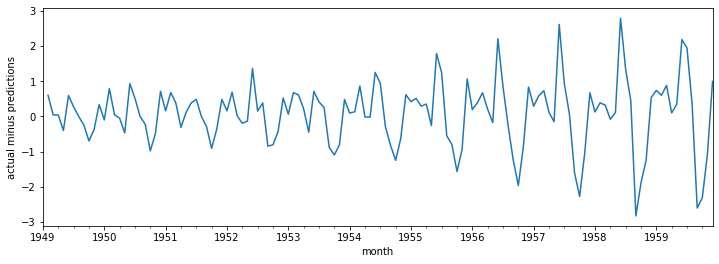

In [40]:
ax = naive1.resid.plot(figsize=(12,4))
ax.set(xlabel='month', ylabel='actual minus predictions');

/home/d5learner-15/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resid', ylabel='Density'>

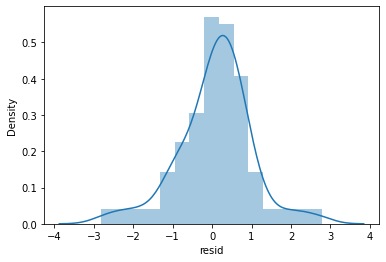

In [41]:
sns.distplot(naive1.resid.dropna())

In [42]:
mean_absolute_percentage_error(train_adj, insample_predictions1)

7.878380383743695

NOTE: The predictions we made above are only for the next step (month) in each timeseries! (not for the next 12 months) This means they are not correctly evaluating the error that we need for the specific task at hand. You can imagine for the simple naive model that a 12 month prediction actually looks like a flat line (using the most recent value). We will see this later.

## ARIMA

Let's try an ARIMA model at last. Using a classical statsitical approach you would select the order of model which produces a model with acceptable residual plots (remember the first part of linear regression module?). Selecting the best model can also be done automatically using packages which do it for you! Wohoo! 🎉

The `pmdarima` package is an excellent forecasting library for building ARIMA models.  I recommend it over and above the options available in core `statsmodels` package.  It is easier to use and offers an `auto_arima()` function that iteratively searches for a model that minimises the **Akaike Information Criterion (AIC)**

* ${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$

where $k$ = number of parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model.  A likelihood function measures the 'goodness' of fit of a model to data given a set of parameters.  

This looks very complicated at first, but all we need to remember that the models we are working with are very flexible. This means that we can easily create complex models that overfit. Recall that overfitting is when a model will predict the training data exceptionally well, but will perform poorly on out of sample data.  The form of AIC means that it rewards models that fit the training data well, but also penalises models with high $k$ (complicated models with lots of parameters).  That means that AIC will prefer simpler models - in turn reducing overfitting.  That's a great formaula for automatically selecting a good ARIMA forecasting model.

There's a large amount of theory about how to build an ARIMA model.  But modern applications tend to opt for the auto approach.

In [43]:
from pmdarima.arima import auto_arima

ARIMA models require data to be stationary. Stationarity includes that both the mean and variance do not change over time. ARIMA models can take into account an increasing mean over time, however not the variance. We therefore need another transformation. A log transformation will take care of this.

In [44]:
train_adj_log = np.log(train_adj)

#select a model that minimises AIC


In [45]:
arima_model = auto_arima(train_adj_log, seasonal=True, m=12, suppress_warnings=True)

/home/d5learner-15/.local/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


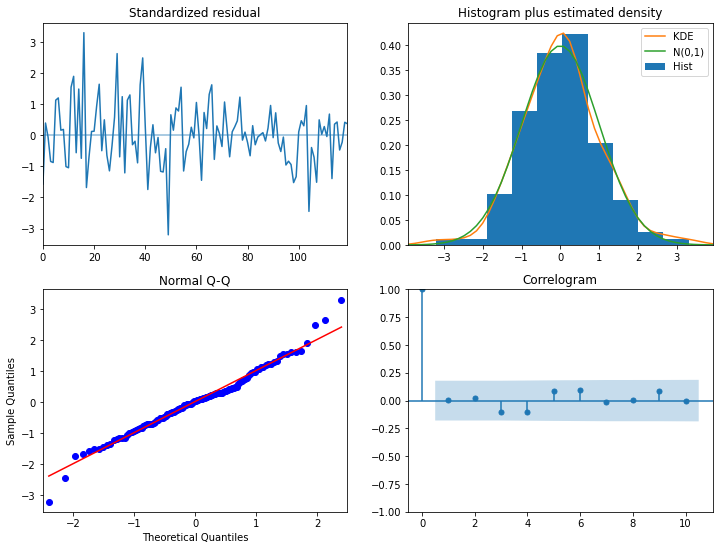

In [46]:
arima_model.plot_diagnostics(figsize=(12,9));

The best model selected is of order (2, 0, 0)x(0, 1, 1, 12) (and the residuals look acceptable). We will use these model in cross validation to estimate our model performance.

We can also specify a model with specific parameters as below.

In [47]:
from pmdarima.arima import ARIMA

In [48]:
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [49]:
model.fit(train_adj_log)

ARIMA(order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

/home/d5learner-15/.local/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


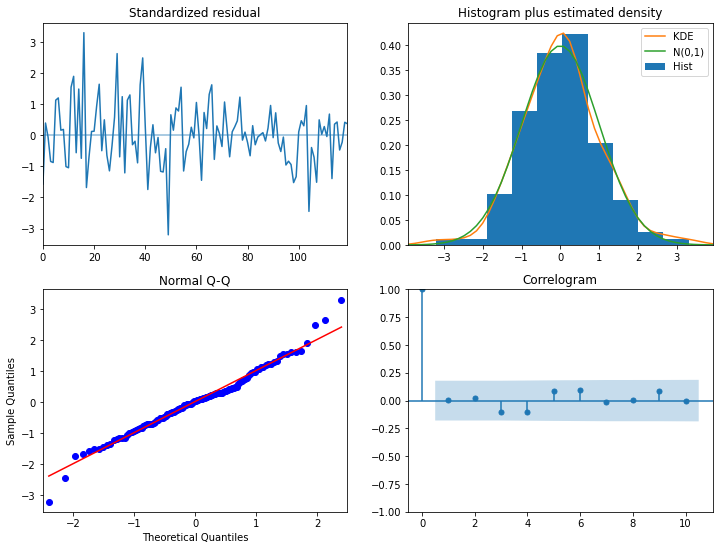

In [50]:
model.plot_diagnostics(figsize=(12,9));

In [51]:
# Standardized residual : on regarde s'il y a des patterns dans les résidus. Si y'en a, c'est qu'on a pê perdu
# une info.

# Histogram plus estimated density : on vérifie la distribution des résidus. Doivent suivre une loi Normale.

# Normal Q-Q : on récupère différents quartiles dans les prédictions et dans les théoriques. Ca devrait être une
# droite. Sinon, c'est que le modèle n'est pas super.

# Correlogram : on décale d'un point et on mesure la corrélation. Si dépasse pas le carré bleu, pas significatif.

## Time series cross-validation

In reality we would use some sort of cross validation. However, we must be careful when using time series which approach we use. We must be careful not to give the model any information from the future that it would not otherwise have at the time of making a forecast. This means we cannot use the standard CV methods which randomise our data that we have used in the past.

In the classicial time series literature time series cross validation is called a **Rolling Forecasting Horizon**. The following code and output provide a simplified view of how rolling forecast horizons work in practice.

In [52]:
full_series = [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222, 1234, 3456]

test = full_series[-2:]
train = full_series[:-2]
print('full training set: {0}'.format(train))
print('hidden test set: {0}'.format(test))


def show_data_is_used_in_cv(train, min_train_size, horizon):
    '''
    Loop through training data and illustrate
    how it would be used in a rolling forecast approach
    to CV.  Assumes that user wants to take steps of 1 in each 
    fold.
    '''
    print('\n**data used in cross-validation**')
    print('**horizon = {}'.format(horizon))
    for i in range(len(train) - min_train_size - horizon + 1):
        print('fold:{0}'.format(i+1))
        print('training\t{0}'.format(train[:min_train_size+i]))
        print('validation\t{0}'.format(train[min_train_size+i:min_train_size+i+horizon]))


for horizon in range(1, 4):
    show_data_is_used_in_cv(train, min_train_size=4, horizon=horizon)

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]
hidden test set: [1234, 3456]

**data used in cross-validation**
**horizon = 1
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900]
fold:3
training	[2502, 2414, 2800, 2143, 2708, 1900]
validation	[2333]
fold:4
training	[2502, 2414, 2800, 2143, 2708, 1900, 2333]
validation	[2222]

**data used in cross-validation**
**horizon = 2
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708, 1900]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900, 2333]
fold:3
training	[2502, 2414, 2800, 2143, 2708, 1900]
validation	[2333, 2222]

**data used in cross-validation**
**horizon = 3
fold:1
training	[2502, 2414, 2800, 2143]
validation	[2708, 1900, 2333]
fold:2
training	[2502, 2414, 2800, 2143, 2708]
validation	[1900, 2333, 2222]


## Timeseries CV with naive models on  airline data

In order to choose between our models we use CV to estimate how we think each will perform on new data.

### Naive models

In [53]:
#I've written a function to help with the cv of the baseline
from forecast.model_selection import time_series_cv

In [54]:
#it requires the data to be split into training and validation.
train, test = ts_train_test_split(airline, '1960-01-01')
train_adj = train / train.index.days_in_month
test_adj = train / train.index.days_in_month
trainCV_adj, valCV_adj = train_adj.iloc[:len(train_adj)//3], train_adj.iloc[len(train_adj)//3:]

cv_scores = time_series_cv(snf, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV_adj,
                           val=valCV_adj,
                           horizons=[12],
                           step=1)

In [55]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

,0
count,77.000000
mean,11.767942
std,4.628764
min,3.139441
25%,7.454399
50%,12.432773
75%,15.723540
max,18.883800


In [56]:
cv_scores = time_series_cv(naive1, 
                           error_func=mean_absolute_percentage_error,
                           train=trainCV_adj,
                           val=valCV_adj,
                           horizons=[12],
                           step=1)

In [57]:
cv_scores = pd.DataFrame(cv_scores)
cv_scores.describe()

,0
count,77.000000
mean,17.235467
std,6.184505
min,9.628901
25%,13.000961
50%,15.476935
75%,20.379299
max,35.934012


The prediction is better for the seasonal-naive forecast. We would choose this as our baseline.

### CV with ARIMA

In [58]:
from pmdarima.arima import ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

In [59]:
#manually create the arima model
model = ARIMA(order=(2,0,0), seasonal_order=(0, 1, 1, 12), suppress_warnings = True)

In [60]:
cv = RollingForecastCV(h=HORIZON, step=10) # initially uses 1/3 of the training size

In [61]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month
# airline_adj = np.log(airline_adj) # transform
train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model

cv_results = cross_val_score(model, train_log, cv=cv, scoring=mean_absolute_percentage_error)

In [62]:
#how many splits did we get?
len(cv_results)

8

In [63]:
pd.DataFrame(cv_results).dropna().describe()

,0
count,8.000000
mean,1.871526
std,1.364250
min,0.544392
25%,0.950065
50%,1.333855
75%,2.591196
max,4.500770


This is a far better model that either of the naive results. We would choose this model over the others. Is it suitable for use in practice?.... ca depend...

**TASK**
* go back and try different step values in the RollingForecastCV
* What changes?
* In each case what size is the data is the model training on?

In [64]:
# more steps = model seems more precise
# less steps = models seems less precise and more long at calculating ?

# size of training data ?

# Predictions and evaluation on the TEST

In [65]:
airline.tail()

1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, dtype: float64

In [66]:
train.tail()

1959-08-01    18.032258
1959-09-01    15.433333
1959-10-01    13.129032
1959-11-01    12.066667
1959-12-01    13.064516
Freq: MS, dtype: float64

In [67]:
# predict 12-steps ahead with naive models
HORIZON = 12
naive1.fit(train)
naive1_preds = naive1.predict(horizon=HORIZON)
snf.fit(train)
snf_preds = snf.predict(horizon=HORIZON)

In [68]:
# predict 12 steps ahead with arima
model.fit(train_log)
arima_preds = model.predict(12)

#### need to back transform the log traisform
arima_preds = np.exp(arima_preds)

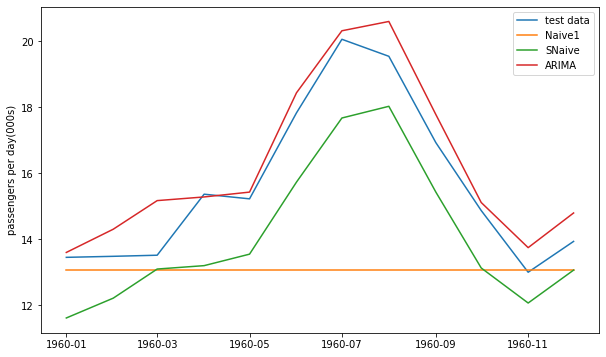

In [69]:
#plot the model predictions
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

axes.plot(test)
axes.plot(pd.Series(naive1_preds, index=test.index));
axes.plot(pd.Series(snf_preds, index=test.index));
axes.plot(pd.Series(arima_preds, index=test.index));
axes.set(ylabel='passengers per day(000s)');
axes.legend(['test data', 'Naive1', 'SNaive','ARIMA']);

## Produce final forecast with chosen model

We want to predict the next 12 steps after the data we currently have.

In [70]:
# fit arima model to whole time series
airline_log = np.log(airline_adj)
model.fit(airline_log)

#make predictions for following 12 periods
final_forecast, cis = model.predict(HORIZON, return_conf_int=True, alpha=0.05)

#### need to back transform the log
final_forecast = np.exp(final_forecast)
cis = np.exp(cis)

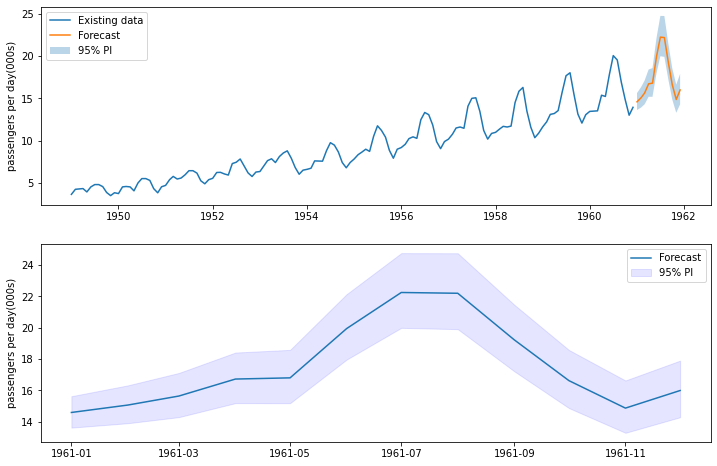

In [71]:
#create an datetime index for the forecast horizon
forecast_index = pd.date_range(start='1961-01-01', periods=HORIZON, freq='MS')

#plot the model with 90% predictions intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(airline_adj)
axes[0].plot(pd.Series(final_forecast, index=forecast_index));



axes[0].set(ylabel='passengers per day(000s)');

limits = pd.DataFrame(cis, index=forecast_index, columns=['lower', 'upper'])
axes[0].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.3, 
                  label='90% PI')

axes[0].legend(['Existing data', 'Forecast', '95% PI']);



axes[1].plot(pd.Series(final_forecast, index=forecast_index));
axes[1].set(ylabel='passengers per day(000s)');

axes[1].fill_between(forecast_index, limits['lower'], limits['upper'], 
                  alpha=.1, 
                  label='90% PI', color='blue')

axes[1].legend(['Forecast', '95% PI']);

# Excercise 1 - Automatize the analysis

TODO: Write a class with the following methods:
* The necessary arguments to split the dataset, fit the auto_arima model etc.
* A `fit` method which fits the auto_arima naive and snaive models using a train dataset
* A `get_metrics` method which computes the MAPE for each models using a test dataset
* A `predict` method which takes as input a prediction horizon and returns predicted values.
* A `plot` method which plots the data, and if available the predictions 

Bonus: 
* Add a method get_cv Which performs cross validation
* To further automatize the process add an automatic detection of the period.
* Add the possibility to apply a preprocessing of the data before the fit: such as a log transformation.




In [83]:
#### Write your code here
class Autoanal:
    def __init__(self,dataset,split_value,period,horizon):
        self.dataset = dataset
        self.split_value = split_value
        self.period = period
        self.horizon = horizon
        self.arima_model = auto_arima(train_adj_log, seasonal=True, m=period, suppress_warnings=True)
        self.snaive_model = SNaive(period=period)
        
        
    def split_and_scale(self):
        """Splits a dataset (a dataframe with time as index) and returns a scaled train and test datasets."""
        train = self.dataset.loc[:str(self.split_value)].iloc[:-1]
        test = self.dataset.loc[str(self.split_value):]
#         train_ajd = train / train.index.days_in_month
#         train_adj_log = np.log(train_adj)
#         test_ajd = test / test.index.days_in_month
#         test_adj_log = np.log(test_adj)        
        return train, test #,train_adj,train_adj_log,test_adj,test_adj_log        
    

         
    def fit(self):
        """Fits two models - auto_arima and seasonal naive - with a training dataset."""        
        self.arima_model.fit(train) #train_adj_log
        self.snaive_model.fit(train) #train_adj
        return self.arima_model,self.snaive_model


    def get_metrics(self):
        """Calculates the MAPE metrics for each model - arima & seasonal naive - using the train dataset."""
        percentage_error_snaive = 100*(train-y_pred_snaive)/train #train_adj
        MAPE_snaive = np.mean(abs(percentage_error_snaive))
        
        percentage_error_arima = 100*(train-y_pred_arima)/train #train_adj
        MAPE_arima = np.mean(abs(percentage_error_arima))
        
        return MAPE_snaive,MAPE_arima
    
    
      
    def predict(self):
        """Takes as input a prediction horizon and returns predicted values for each model."""
        y_pred_snaive = self.snaive_model.predict(horizon=self.horizon)
        pred_arima = self.arima_model.predict(self.horizon)
        y_pred_arima = np.exp(pred_arima)
        return y_pred_snaive,y_pred_arima
    
    
    
    def plot(self):
        """Plots the test data, the predictions for each model and the diagnostics for arima model."""
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
        axes[0].plot(test)
        axes[0].plot(pd.Series(y_pred_snaive, index=test.index));
        axes[0].plot(pd.Series(y_pred_arima, index=test.index));
        axes[0].set(ylabel='passengers per day(000s)');
        axes[0].legend(['test data', 'SNaive','ARIMA']);
        
        axes[1].self.arima_model.plot_diagnostics(figsize=(12,9));

TODO: Test this method on all the other [11 datasets](https://alkaline-ml.com/pmdarima/modules/classes.html#module-pmdarima.datasets) of pmdarima. To help you, we provide the list of dataset names and a function to load any of these datasets.

On some of them the method does not work well, why? What could be done to improve it?

In [73]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [74]:
#### Write your code here
airpassengers=get_ds('airpassengers')
airpassengers

0      112.0
1      118.0
2      132.0
3      129.0
4      121.0
       ...  
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Length: 144, dtype: float64

In [84]:
airpass_anal=Autoanal(airpassengers,'1960-01-01',12,12)

In [85]:
train, test= airpass_anal.split_and_scale()

In [86]:
airpass_anal.fit()

(ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
       suppress_warnings=True),
 <forecast.baseline.SNaive at 0x7f3fbaccc7f0>)

In [87]:
y_pred_snaive,y_pred_arima = airpass_anal.predict()

In [88]:
MAPE_snaive,MAPE_arima = airpass_anal.get_metrics()

ValueError: operands could not be broadcast together with shapes (19,) (12,) 

ValueError: Length of passed values is 12, index implies 124.

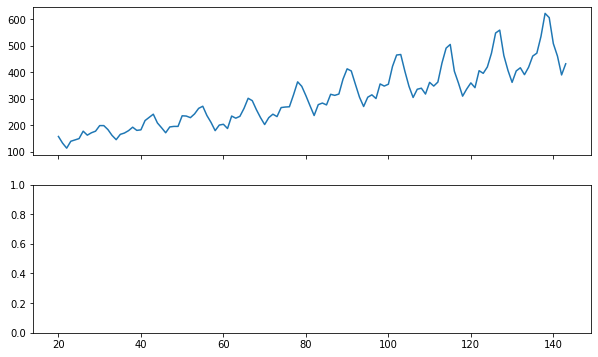

In [89]:
airpass_anal.plot()